In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
import pickle as pk
from sklearn.metrics import silhouette_score, silhouette_samples
from networkx.linalg.graphmatrix import adjacency_matrix

import hashlib
##
from clustering import read_network

### Parameters to Modify

In [11]:
net_name = 'SymbC1' # TODO: options: 'Pdam', 'SymbC1'


BASE_DIR = './'
DATA_DIR = f'{BASE_DIR}data/'
OUTPUT_DIR = f'{BASE_DIR}results/'


# POST_DSD_PARAMS:
edge_weight_thresh = 0.5
kclusts = None
random_seed = 6191998
min_clust_size = 3
cluster_divisor = 20 # yields max size of 30

# SPECTRAL CLUSTERING PARAMS:
init_kclusts = 500

### End Parameters to Modify

In [12]:

# Assuming that the data has been downloaded from the google drive link, and net_name is either 'Pdam' or 'SymbC1', these do not need to be modified
go_db_file =f"{DATA_DIR}/go.obo"

interactionFile = f'{DATA_DIR}/{net_name}_predictions_positive.tsv'
DSDfile = f'{DATA_DIR}/{net_name}_dscript_distances.DSD1.tsv' 

initial_SC_pickle_file = f"{OUTPUT_DIR}{net_name}.initSC.pkl"
cluster_size_dist_file = f"{OUTPUT_DIR}{net_name}.clust_size_dist.png"
initial_clusters_output_file = f"{OUTPUT_DIR}{net_name}.clusters.csv"

post_recipe_clusters_filepath = f"./{OUTPUT_DIR}{net_name}.recipe_clusters.csv" # TODO: put this in relation to dir and netname


print(f"pre-recipe clusters will be saved to {initial_clusters_output_file}")

pre-recipe clusters will be saved to ./results/SymbC1.clusters.csv


Post recipe writing clusters to files

In [6]:
# TODO: CLEAN THIS

from pyvis.network import Network as PyvizNetwork
COLAB_ENV = False

class NetworkViz(PyvizNetwork):
    """Extend PyVis class so that we can use a modified template that works in Colab. 
    """
 
    def __init__(self,
                 height="500px",
                 width="500px",
                 directed=False,
                 notebook=False,
                 bgcolor="#ffffff",
                 font_color=False,
                 layout=None,
                 heading=""):
        # call super class init
        PyvizNetwork.__init__(self, 
                              height, 
                              width,
                              directed,
                              notebook,
                              bgcolor,
                              font_color,
                              layout,
                              heading=heading)
        # override template location - update as per installation
        #self.path =  os.path.abspath(os.path.join(os.path.dirname( __file__ ), '..', 'templates/pyvis_inline.html'))


    # fun copied from pyvis to skip imports
    def check_html(self, name):
        """
        Given a name of graph to save or write, check if it is of valid syntax
        :param: name: the name to check
        :type name: str
        """
        assert len(name.split(".")) >= 2, "invalid file type for %s" % name
        assert name.split(
            ".")[-1] == "html", "%s is not a valid html file" % name

    # fun extended for colab
    def show(self, name):
        """
        Writes a static HTML file and saves it locally before opening.
        :param: name: the name of the html file to save as
        :type name: str
        """
        self.check_html(name)
        if self.template is not None:
            if not COLAB_ENV: 
                # write file and return IFrame
                return self.write_html(name, notebook=True)
            else:
                # write file and return HTML
                self.write_html(name, notebook=True)
                return IPython.display.HTML(data=name)
        else:
            self.write_html(name)
            webbrowser.open(name)

class Cluster:
    def __init__(self,proteins):
        self.proteins = proteins

    def __len__(self):
        return len(self.proteins)

    def __repr__(self): # NOTE: 
        reprStr = "Cluster of {} [{},{},...] (hash {})".format(len(self), self.proteins[0], self.proteins[1], hash(self))
        if hasattr(self, 'G'):
            reprStr += "\nTriangles: {}\nMax Degree: {}".format(self.triangles(), max(self.G.degree(), key=lambda x: x[1])[1])
        if hasattr(self, 'GO_terms'):
            reprStr += "\nTop Terms:\n\t{}".format('\n\t'.join(
                    ['{} ({})'.format(i[0], i[1]) for i in self.get_top_terms(5)]
            ))
        return reprStr

    def __hash__(self):
        return int(hashlib.md5(''.join(self.proteins).encode()).hexdigest(), 16)
    
    def __iter_(self):
        return iter(self.proteins)

    def to_dict(self): # NOTE: 
        D = {}
        D['id'] = hash(self)
        D['proteins'] = []
        for p in self.proteins:
            pD = {}
            pD['name'] = p
            if hasattr(self, 'GO_DB'):
                pD['go'] = self.GO_DB[self.GO_DB['seq'] == p]['GO_ids'].values[0]
            D['proteins'].append(pD)
        if hasattr(self, 'GO_DB'):
            D['go'] = sorted([{"id": i.ID, "desc": i.name, "freq": self.GO_terms[i]} for i in self.GO_terms], key = lambda x: x['freq'], reverse=True)
        if hasattr(self,'G'):
            D['graph'] = list(self.G.edges())
        return D

    def to_json(self): # NOTE:
        return json.dumps(self.to_dict())

    def add_GO_terms(self, go_db, GO_OBJECTS):
        self.GO_terms = {}
        self.GO_DB = go_db
        for prot in self.proteins:
            goIds = go_db[go_db['seq'] == prot]['GO_ids'].values[0]
            if goIds is None or len(goIds) == 0:
                continue
            for gid in goIds:
                try:
                    goObj = GO_OBJECTS[gid]
                except KeyError:
                    GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gid})
                    goObj = GO_OBJECTS[gid]
                goCount = self.GO_terms.setdefault(goObj,0)
                self.GO_terms[goObj] = goCount + 1

    def get_proteins_by_GO(self, GO_id):
        return [p for p in self.proteins if GO_id in prot_go_db.loc[p,'GO_ids']]

    def get_GO_by_protein(self, protein):
        assert protein in self.proteins, "{} not in cluster".format(protein)
        return [gt for gt in coi.GO_terms if gt.ID in prot_go_db.loc[protein,'GO_ids']]

    def get_top_terms(self,N):
        if not hasattr(self, 'GO_terms'):
            raise NotImplementedError("GO Terms have not been added yet.")
        GOlist = list(self.GO_terms.keys())
        if N == -1:
            N = len(GOlist)
        sortedList = sorted(GOlist,key=lambda x: self.GO_terms[x],reverse=True)[:N]
        return list(zip(sortedList, [self.GO_terms[i] for i in sortedList]))

    def set_graph(self,G):
        self.G = G.subgraph(self.proteins)

    def triangles(self):
        return sum([i for i in nx.triangles(self.G).values()]) / 3

    def draw_degree_histogram(self,draw_graph=True):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        if draw_graph:
            plt.axes([0.4, 0.4, 0.5, 0.5])
            pos = nx.spring_layout(G, k=0.15,iterations=10)
            plt.axis('off')
            nx.draw_networkx_nodes(G, pos, node_size=20)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
        plt.show()

    def draw_graph(self, buttons=False):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        net = NetworkViz(width="500px", height="500px", notebook=True)
        net.from_nx(self.G)
        if buttons: net.show_buttons()
        return net.show(f"{hash(self)}_graph.html")
        #nx.draw_kamada_kawai(G, with_labels=True,node_size=600, font_size=8)
    
def readClusterObjects(infile,sep=','):
    clusts = []
    with open(infile,'r') as f:
        for line in f:
            clusts.append(Cluster(line.strip().split(sep)))
    return clusts

def cluster_from_json(jsonString, GO_OBJECTS):
        clust = Cluster([])
        D = json.loads(jsonString)
        clust.proteins = [i['name'] for i in D['proteins']]
        clust.GO_terms = {}
        for goDict in D['go']:
            gid = goDict['id']
            gdesc = goDict['desc']
            try:
                goObj = GO_OBJECTS[gid]
            except KeyError:
                GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gdesc})
                goObj = GO_OBJECTS[gid]
            clust.GO_terms[goObj] = goDict['freq']
        try:
            edgeList = D['graph']
            G = nx.Graph()
            for e in edgeList:
                G.add_edge(*e)
            clust.G = G
        except KeyError:
            pass
        return clust

class GO:
    def __init__(self, ID, features):
        self.ID = ID
        self.D = features
        self.name = features['name']

    def __repr__(self):
        return '{} - <{}>'.format(self.ID, self.name)

    def __eq__(self, other):
        return self.ID == other.ID

    def __hash__(self):
        return hash(self.ID)

def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None

def read_GO_obo(infile): # TODO: throw errors 
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tDict[line[0]] = ''.join(line[1:])
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = v.strip()
                    tDict[k] = v
                terms[tDict['id']] = GO(tDict['id'], tDict)
    return terms
    
def triangle_search(clusters, min_triangles=0, max_triangles=np.infty):
    return [c for c in clusters if c.triangles() >= min_triangles and c.triangles() <= max_triangles]

def node_search(clusters, min_nodes=0, max_nodes=np.infty):
    return [c for c in clusters if len(c) >= min_nodes and len(c) <= max_nodes]


reading clusters from ././results/SymbC1.recipe_clusters.csv
Reading DSD File: ./data//SymbC1_dscript_distances.DSD1.tsv...
Selecting DSD connected component...
Filtering edges with confidence threshold 0.5...


  0%|          | 0/394137 [00:00<?, ?it/s]

                 SymbC1
                       
Nodes              7928
Edges            394137
Degree (Med)       34.0
Degree (Avg)  99.429112
Sparsity       0.006271
Saving Degree Distribution Plot to:  ./results/SymbC1.degree_dist.png


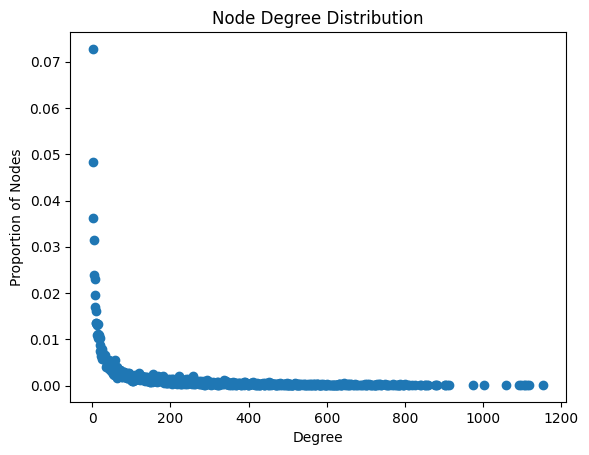

In [29]:
print(f"reading clusters from {post_recipe_clusters_filepath}")
clusters = readClusterObjects(post_recipe_clusters_filepath)

G, DSD, protein_names = read_network(DSDfile, interactionFile, edge_weight_thresh=edge_weight_thresh, net_name=net_name, output_stats=True, results_dir=OUTPUT_DIR)
fullNetwork = Cluster(protein_names) 
fullNetwork.set_graph(G)
for i in clusters:
    i.set_graph(G)

In [31]:
def clean_GO_map(f):
    seqDb = pd.read_csv(f,sep=',')
    seqDb.columns = ['seq','manual_annot','pfam_list','GO_list']
    seqDb['GO_str'] = seqDb['GO_list']
    seqDb['GO_list'] = seqDb['GO_str'].str.split(';')
    def extract_GO_id_from_list(l):
        if isinstance(l,list):
            return [i.split('|')[0] for i in l]
        else:
            return None
    seqDb['GO_ids'] = seqDb['GO_list'].apply(extract_GO_id_from_list)
    seq2GO = seqDb[['seq','GO_ids']]
    seq2GO.columns = ['seq','GO_ids']
    return seq2GO

In [32]:

pdamMap = clean_GO_map(f'{DATA_DIR}Pdam_GO_map.csv') # TODO: should be able to generate, but will have to figure out rohit's process 
symbMap = clean_GO_map(f'{DATA_DIR}SymbC1_GO_map.csv')
goMap = pd.concat((pdamMap, symbMap))

In [33]:
GO_OBJECTS = read_GO_obo(go_db_file)
print('Adding GO Annotations...')
for clust in tqdm(clusters):
    clust.add_GO_terms(goMap,GO_OBJECTS)
fullNetwork.add_GO_terms(goMap,GO_OBJECTS)
clusters.sort(key=lambda x: len(x), reverse=True)

Adding GO Annotations...


  0%|          | 0/307 [00:00<?, ?it/s]

# AND NOW THE CLUSTERS ARE DONE!

WHAT TO DO WITH CLUSTERS:
- print them:

In [36]:
# NOTE: this is added to be able to print the clusters to files for lenore
summary_output_filename = f'{BASE_DIR}{net_name}_pretty_clusters_summary.txt'
with (open(summary_output_filename, 'w+')) as f:
    for i in clusters:
        f.write(i.__repr__() + '\n')
    # f.write(json.dumps([i.to_dict() for i in clusters]))
print(f"pretty summary printed to {summary_output_filename}")
hash_to_proteins_file = f'{BASE_DIR}{net_name}_hash_to_proteins.json'
with (open(hash_to_proteins_file, 'w+')) as f:
    for i in clusters:
        f.write(json.dumps({hash(i): i.proteins}) + '\n')
print(f"cluster info printed to {hash_to_proteins_file}")


pretty summary printed to ./SymbC1_pretty_clusters_summary.txt
cluster info printed to ./SymbC1_hash_to_proteins.json


- Analysis of clusters (how many times were proteins added back)

Text(0.5, 1.0, 'Distribution of proteins added (SymbC1)')

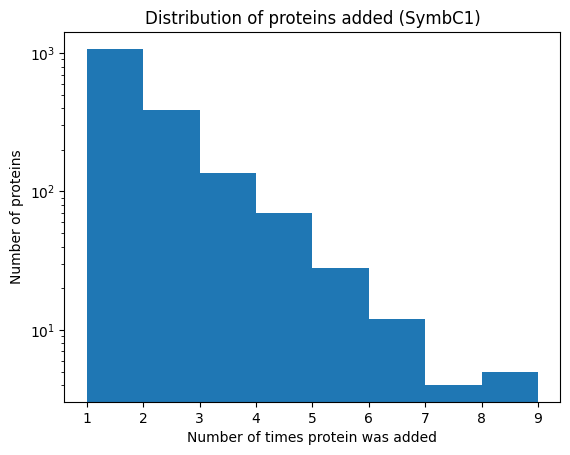

In [41]:
# graph


import collections
recipe_json = f"./results/{net_name}.recipe_clusters.json"

# determine distribution of protein re-addition.
recipe_prots = {}
with open(recipe_json) as f:
    recipe_prots = json.load(f)

# create a default dict where the key is a protein and the initial val is 0
# then for each cluster, increment the count for each protein in the cluster
prot_counts = collections.defaultdict(int)
for k in recipe_prots["degree"]["0.75"].keys():
    for prot in recipe_prots["degree"]["0.75"][k]:
        prot_counts[prot] += 1

# plot the distribution of proteins added
plt.hist(prot_counts.values(), bins=range(1, max(prot_counts.values())+1))
plt.xlabel('Number of times protein was added')
plt.ylabel('Number of proteins')

# make y axis log scale
plt.yscale('log')
# add count on the top of the histogram bar

plt.title(f'Distribution of proteins added ({net_name})')